In [248]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

import os
from transformers import BertModel, BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [249]:
path = '../BBBP.csv'
# Kaggle
path = '/kaggle/input/bbbp-smiles/BBBP.csv'

df = pd.read_csv(path)
df['length'] = df['smiles'].apply(len)
bin_size = 10
df['bin'] = pd.qcut(df['length'], q=10, labels=False, duplicates='drop')
bin_indices = {bin_name: bin_data.index.tolist() for bin_name, bin_data in df.groupby('bin')}
df.head()

,num,name,p_np,smiles,length,bin
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,32,2
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,40,3
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,50,5
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,32,2
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,66,7


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


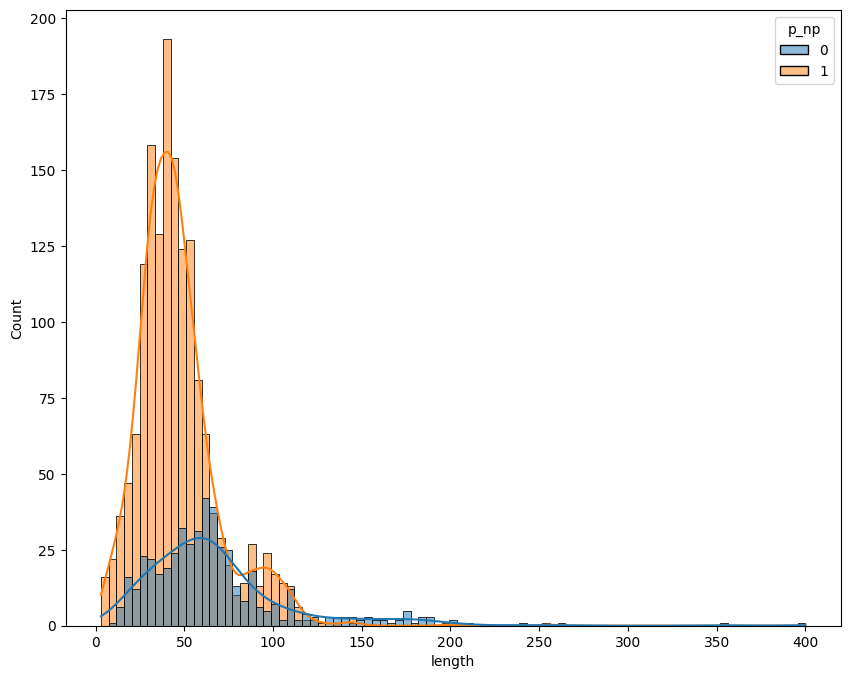

In [250]:
plt.figure(figsize=(10,8))
sns.histplot(data = df, x = 'length',hue='p_np',kde=True);

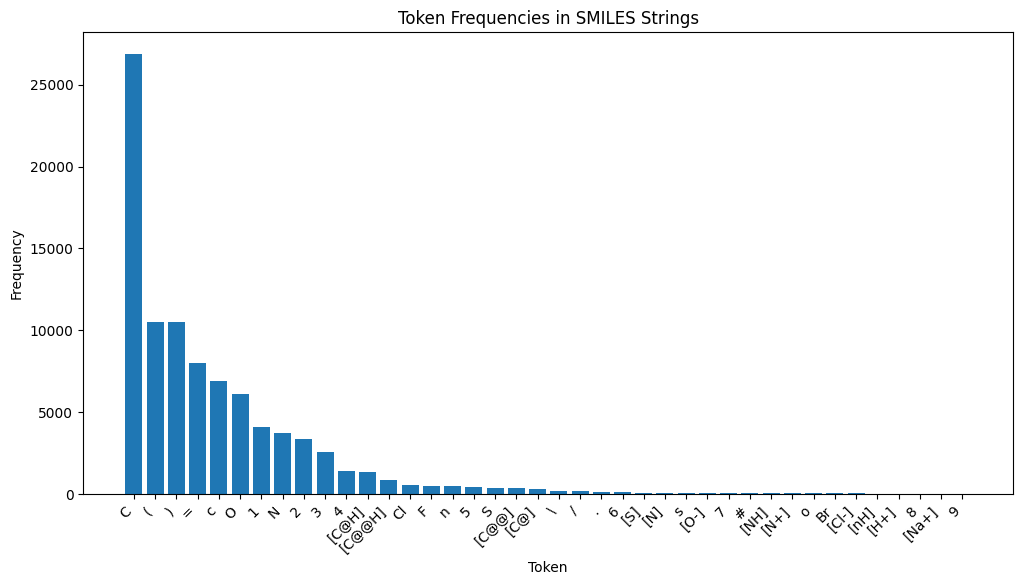

Vocab {'[N+]', 's', '[C@H]', '[nH]', '[O-]', '[n+]', '[NH3+]', 'O', '[H]', '[H+]', '[Na+]', 'S', '[NH-]', '5', '%12', '[NH]', ')', '[Cl-]', '#', 'F', '.', 'Br', '%10', '1', '[C-]', '2', '/', '[o+]', 'n', '[S]', '[NH2]', '[O+]', '[C@@]', '[C@]', '%13', '3', '[CH2-]', 'o', 'I', '[Br-]', '=', '7', '[NH+]', '\\', '[N]', '[CH-]', '[nH+]', '[Na]', '(', 'C', 'c', '8', '%11', '[S+]', '[NH2+]', 'B', '[P]', '[OH-]', '4', '9', '[S@]', '[C@@H]', '6', '[N@@]', '[N@]', '[Ca++]', 'Cl', '%14', '[Cl]', '[N-]', 'N'}
Vocab Size 71


In [251]:
from collections import Counter
import re

smiles_list = df['smiles']
# From DeepChem
SMILE_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""

all_tokens = ''.join(smiles_list)
tokens = re.findall(SMILE_REGEX_PATTERN, all_tokens)

unique_tokens = set(tokens)
token_counter = Counter(tokens)

# Plotting
top_n_tokens = 40
top_tokens = dict(token_counter.most_common(top_n_tokens))
plt.figure(figsize=(12, 6))
plt.bar(top_tokens.keys(), top_tokens.values())
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.title('Token Frequencies in SMILES Strings')
plt.show()

print("Vocab",unique_tokens)
print("Vocab Size",len(unique_tokens))

In [252]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Create a mapping from token to its index
token_to_index = {token: i+2 for i, token in enumerate(unique_tokens)}
token_to_index['PAD'] = 0
token_to_index['UNK'] = 1

# Tokenize
smiles_encoded = df['smiles'].apply(lambda x: [token_to_index[token] for token in re.findall(SMILE_REGEX_PATTERN, x)])

# Padding sequences on the left side
max_length = 128
# max_length = max(map(len, smiles_encoded))
smiles_padded = [[token_to_index['PAD']] * (max_length - len(seq)) + seq[-max_length:] if len(seq) < max_length else seq[-max_length:] for seq in smiles_encoded]
smiles_tensor = torch.tensor(smiles_padded)

# One hot encoding
encoder = OneHotEncoder(categories='auto', sparse_output=False)
smiles_onehot = encoder.fit_transform(smiles_tensor.view(-1, 1))
smiles_onehot = smiles_onehot.reshape(smiles_tensor.shape[0], max_length, -1)

print("One-hot encoded SMILES matrix shape:", smiles_onehot.shape)


One-hot encoded SMILES matrix shape: (2050, 128, 72)


In [253]:
from sklearn.model_selection import train_test_split

X_MLP = smiles_onehot.reshape(smiles_onehot.shape[0],-1)
Y = torch.Tensor(df['p_np'])

# Split the data into training and testing sets
X_train_MLP, X_test_MLP, Y_train_MLP, Y_test_MLP = train_test_split(X_MLP, Y, test_size=0.2, random_state=42)
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(smiles_onehot, Y, test_size=0.2, random_state=42)

train_dataset_MLP = TensorDataset(torch.Tensor(X_train_MLP), torch.Tensor(Y_train_MLP))
test_dataset_MLP = TensorDataset(torch.Tensor(X_test_MLP), torch.Tensor(Y_test_MLP))
train_dataset_LSTM = TensorDataset(torch.Tensor(X_train_LSTM), torch.Tensor(Y_train_LSTM))
test_dataset_LSTM = TensorDataset(torch.Tensor(X_test_LSTM), torch.Tensor(Y_test_LSTM))

batch_size = 256
train_loader_MLP = DataLoader(
    train_dataset_MLP, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=False
)
test_loader_MLP = DataLoader(
    test_dataset_MLP, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=False
)
train_loader_LSTM = DataLoader(
    train_dataset_LSTM, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=False
)
test_loader_LSTM = DataLoader(
    test_dataset_LSTM, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=False
)

In [254]:
def train_model(model, dataset, num_epochs, print_every=5):
    from tqdm import tqdm

    loss_list = []
    accuracy_list = []

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0

        for inputs, labels in tqdm(dataset, desc=f'epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.reshape_as(labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Measure accuracy
            predicted = (outputs > 0.5).float() 
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            running_accuracy += correct / total

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader_MLP)
        epoch_accuracy = running_accuracy / len(train_loader_MLP)

        scheduler.step()

        loss_list.append(epoch_loss)
        accuracy_list.append(epoch_accuracy)

        if (epoch + 1) % print_every == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {100*epoch_accuracy:.2f}%')
            
    return loss_list, accuracy_list


In [255]:
def plot_loss_acc(loss_list, accuracy_list):
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(loss_list, label='Loss', marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(accuracy_list, label='Accuracy', marker='o', color='orange')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [256]:
def eval_model(model, dataset):
    model.eval()
    running_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(dataset):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float() 
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            running_accuracy += correct / total
        test_accuracy = sum(accuracy_list) / len(accuracy_list)

    return test_accuracy

In [257]:
input_size = X_train_MLP.shape[-1]
fc_model = nn.Sequential(
    nn.Linear(input_size, 1),
    nn.Sigmoid()
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

fc_model

Sequential(
  (0): Linear(in_features=9216, out_features=1, bias=True)
  (1): Sigmoid()
)

epoch 5/20: 100%|██████████| 7/7 [00:00<00:00, 29.58it/s]


Epoch 5/20, Loss: 0.2357, Accuracy: 89.69%


epoch 10/20: 100%|██████████| 7/7 [00:00<00:00, 29.59it/s]


Epoch 10/20, Loss: 0.1599, Accuracy: 94.70%


epoch 15/20: 100%|██████████| 7/7 [00:00<00:00, 28.59it/s]


Epoch 15/20, Loss: 0.1567, Accuracy: 94.80%


epoch 20/20: 100%|██████████| 7/7 [00:00<00:00, 28.70it/s]


Epoch 20/20, Loss: 0.1499, Accuracy: 95.08%


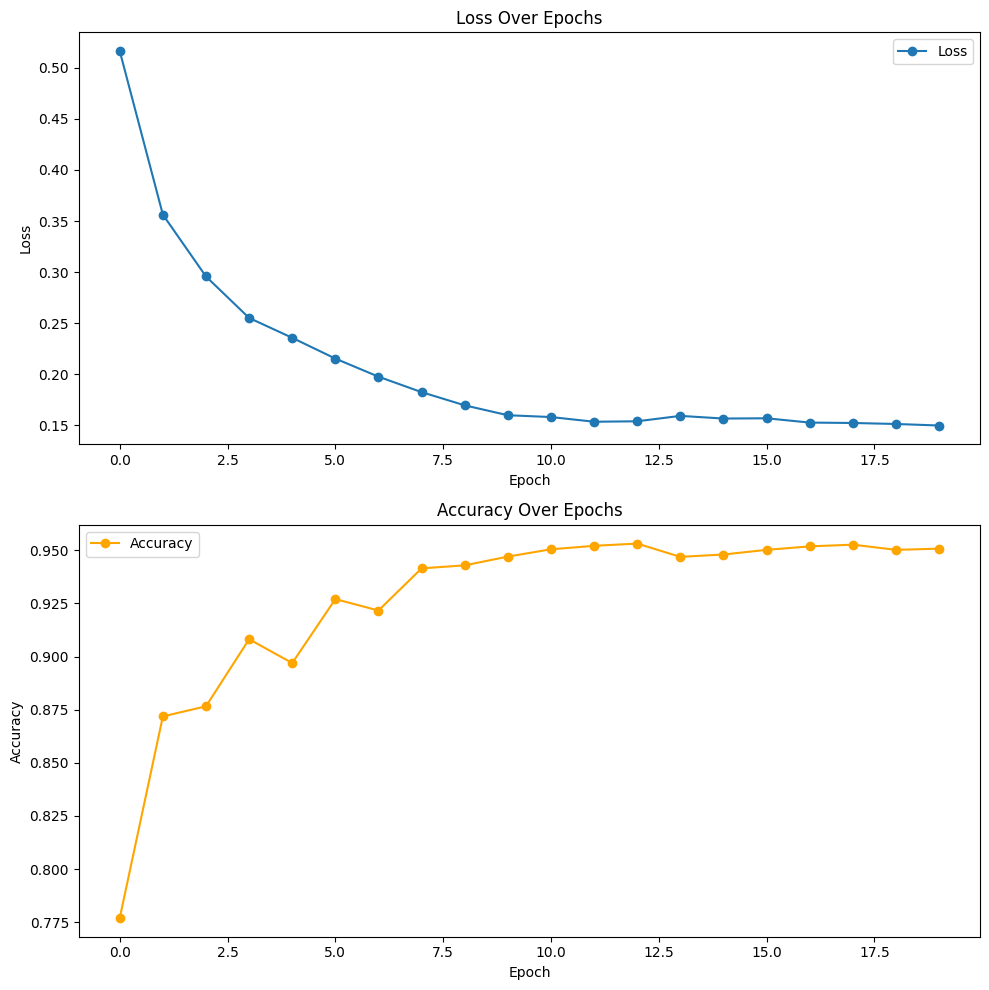

In [258]:
loss_list, accuracy_list = train_model(fc_model, train_loader_MLP, num_epochs=20)
plot_loss_acc(loss_list, accuracy_list)

In [259]:
test_accuracy_FC = eval_model(fc_model, test_loader_MLP)
print(f'Fully connected model accuracy over test dataset: {100*test_accuracy_FC:.2f}%')

100%|██████████| 2/2 [00:00<00:00, 11.12it/s]

Fully connected model accuracy over test dataset: 92.58%


In [260]:
class LSTM_smiles(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(LSTM_smiles, self).__init__()
        self.input_size_var = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        # Make the initial states a learnable constant
        self.h0 = Parameter(
            torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 1, self.hidden_size)
        )
        self.c0 = Parameter(
            torch.zeros_like(self.h0)
        )
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(2 * hidden_size if self.bidirectional else hidden_size, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        h0 = self.h0.expand(-1, x.size(0), -1).contiguous().to(x.device)
        c0 = self.c0.expand(-1, x.size(0), -1).contiguous().to(x.device)
        
        # (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        if self.bidirectional:
            out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)
        else:
            out = out[:, -1, :].reshape(out.shape[0], -1)
        
        # Fully connected head
        out = self.fc(out)
        out = self.act(out)
        return out


In [261]:
input_size = X_train_LSTM.shape[-1]
lstm_model = LSTM_smiles(
    input_size,
    hidden_size = 64,
    num_layers = 4,
    bidirectional = False,
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

lstm_model

LSTM_smiles(
  (lstm): LSTM(72, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)

epoch 5/50: 100%|██████████| 7/7 [00:00<00:00, 24.98it/s]


Epoch 5/50, Loss: 0.4066, Accuracy: 77.60%


epoch 10/50: 100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


Epoch 10/50, Loss: 0.3146, Accuracy: 86.84%


epoch 15/50: 100%|██████████| 7/7 [00:00<00:00, 23.69it/s]


Epoch 15/50, Loss: 0.2829, Accuracy: 87.95%


epoch 20/50: 100%|██████████| 7/7 [00:00<00:00, 24.26it/s]


Epoch 20/50, Loss: 0.2641, Accuracy: 89.14%


epoch 25/50: 100%|██████████| 7/7 [00:00<00:00, 23.41it/s]


Epoch 25/50, Loss: 0.2607, Accuracy: 88.73%


epoch 30/50: 100%|██████████| 7/7 [00:00<00:00, 24.13it/s]


Epoch 30/50, Loss: 0.2621, Accuracy: 88.65%


epoch 35/50: 100%|██████████| 7/7 [00:00<00:00, 23.90it/s]


Epoch 35/50, Loss: 0.2664, Accuracy: 88.67%


epoch 40/50: 100%|██████████| 7/7 [00:00<00:00, 23.92it/s]


Epoch 40/50, Loss: 0.2662, Accuracy: 88.73%


epoch 45/50: 100%|██████████| 7/7 [00:00<00:00, 23.29it/s]


Epoch 45/50, Loss: 0.2554, Accuracy: 89.14%


epoch 50/50: 100%|██████████| 7/7 [00:00<00:00, 23.54it/s]


Epoch 50/50, Loss: 0.2621, Accuracy: 88.81%


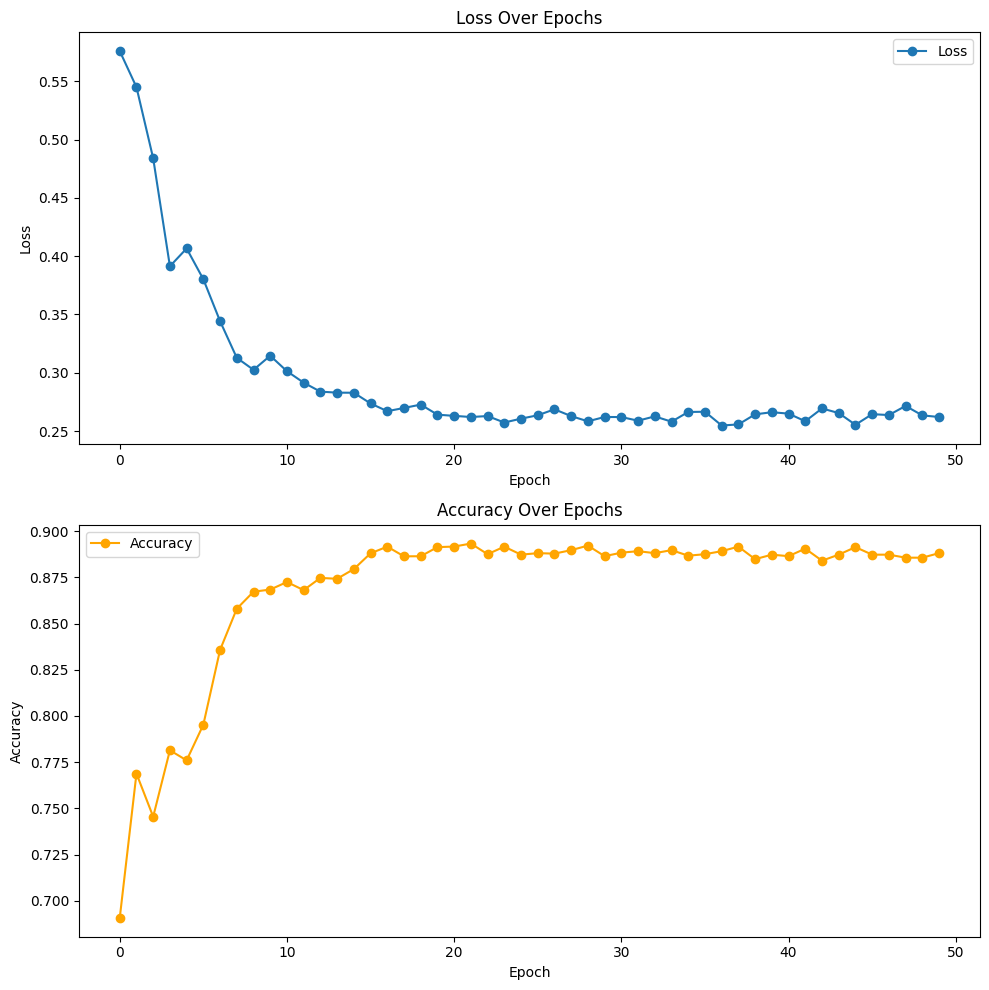

In [262]:
loss_list, accuracy_list = train_model(lstm_model, train_loader_LSTM, num_epochs=50)
plot_loss_acc(loss_list, accuracy_list)

In [263]:
test_accuracy_LSTM = eval_model(lstm_model, test_loader_LSTM)
print(f'LSTM model accuracy over test dataset: {100*test_accuracy_LSTM:.2f}%')

100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

LSTM model accuracy over test dataset: 86.90%


In [264]:
input_size = X_train_LSTM.shape[-1]
bilstm_model = LSTM_smiles(
    input_size,
    hidden_size = 64,
    num_layers = 4,
    bidirectional = True,
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

bilstm_model

LSTM_smiles(
  (lstm): LSTM(72, 64, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)

epoch 5/50: 100%|██████████| 7/7 [00:00<00:00, 19.38it/s]


Epoch 5/50, Loss: 0.4936, Accuracy: 76.48%


epoch 10/50: 100%|██████████| 7/7 [00:00<00:00, 18.67it/s]


Epoch 10/50, Loss: 0.3290, Accuracy: 84.01%


epoch 15/50: 100%|██████████| 7/7 [00:00<00:00, 19.00it/s]


Epoch 15/50, Loss: 0.3175, Accuracy: 86.02%


epoch 20/50: 100%|██████████| 7/7 [00:00<00:00, 17.90it/s]


Epoch 20/50, Loss: 0.2977, Accuracy: 87.61%


epoch 25/50: 100%|██████████| 7/7 [00:00<00:00, 19.64it/s]


Epoch 25/50, Loss: 0.2920, Accuracy: 87.86%


epoch 30/50: 100%|██████████| 7/7 [00:00<00:00, 20.25it/s]


Epoch 30/50, Loss: 0.2858, Accuracy: 88.50%


epoch 35/50: 100%|██████████| 7/7 [00:00<00:00, 18.34it/s]


Epoch 35/50, Loss: 0.2907, Accuracy: 87.79%


epoch 40/50: 100%|██████████| 7/7 [00:00<00:00, 19.24it/s]


Epoch 40/50, Loss: 0.2821, Accuracy: 88.22%


epoch 45/50: 100%|██████████| 7/7 [00:00<00:00, 18.95it/s]


Epoch 45/50, Loss: 0.2885, Accuracy: 87.98%


epoch 50/50: 100%|██████████| 7/7 [00:00<00:00, 19.14it/s]


Epoch 50/50, Loss: 0.2822, Accuracy: 88.52%


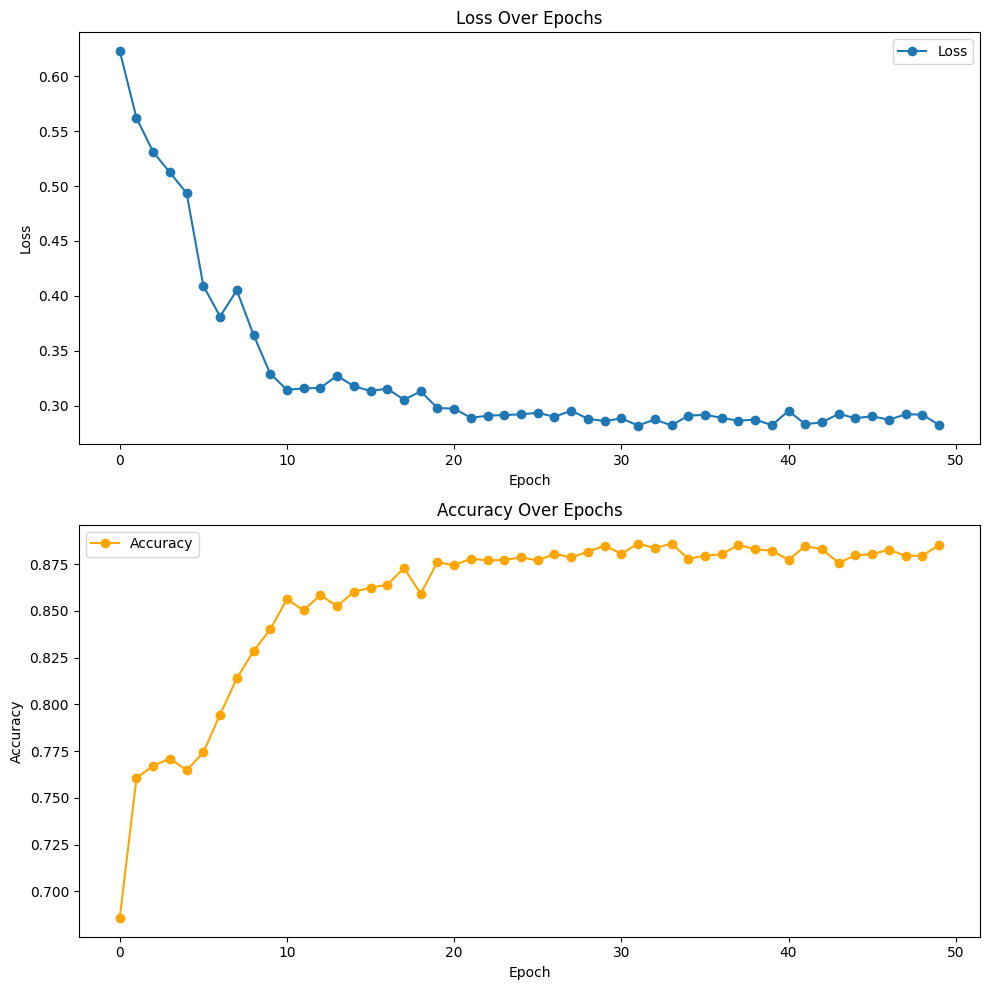

In [265]:
loss_list, accuracy_list = train_model(bilstm_model, train_loader_LSTM, num_epochs=50)
plot_loss_acc(loss_list, accuracy_list)

In [266]:
test_accuracy_BiLSTM = eval_model(bilstm_model, test_loader_LSTM)
print(f'BiLSTM model accuracy over test dataset: {100*test_accuracy_BiLSTM:.2f}%')

100%|██████████| 2/2 [00:00<00:00,  9.94it/s]

BiLSTM model accuracy over test dataset: 85.67%


In [267]:
from torch.nn.parameter import Parameter


class RNN_smiles(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(RNN_smiles, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        # Make the initial states a learnable constant
        self.h0 = Parameter(
            torch.zeros(self.num_layers * 2 if self.bidirectional else self.num_layers, 1, self.hidden_size)
        )
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(2 * hidden_size if self.bidirectional else hidden_size, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        # Set initial hidden state
        h0 = self.h0.expand(-1, x.size(0), -1).contiguous().to(x.device)
        
        # (batch_size, seq_length, hidden_size)
        out, _ = self.rnn(x, h0)
        
        if self.bidirectional:
            # Concatenate the last hidden state from both directions
            out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)
        else:
            # Use the last hidden state from the single direction
            out = out[:, -1, :]
        
        # Fully connected head
        out = self.fc(out)
        out = self.act(out)
        return out

In [268]:
input_size = X_train_LSTM.shape[-1]
rnn_model = RNN_smiles(
    input_size,
    hidden_size = 64,
    num_layers = 4,
    bidirectional = False,
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

rnn_model

RNN_smiles(
  (rnn): RNN(72, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)

epoch 5/50: 100%|██████████| 7/7 [00:00<00:00, 26.69it/s]


Epoch 5/50, Loss: 0.5430, Accuracy: 76.72%


epoch 10/50: 100%|██████████| 7/7 [00:00<00:00, 27.29it/s]


Epoch 10/50, Loss: 0.4947, Accuracy: 74.46%


epoch 15/50: 100%|██████████| 7/7 [00:00<00:00, 27.24it/s]


Epoch 15/50, Loss: 0.4590, Accuracy: 77.40%


epoch 20/50: 100%|██████████| 7/7 [00:00<00:00, 27.28it/s]


Epoch 20/50, Loss: 0.4366, Accuracy: 79.46%


epoch 25/50: 100%|██████████| 7/7 [00:00<00:00, 26.19it/s]


Epoch 25/50, Loss: 0.4397, Accuracy: 79.80%


epoch 30/50: 100%|██████████| 7/7 [00:00<00:00, 27.78it/s]


Epoch 30/50, Loss: 0.4388, Accuracy: 79.64%


epoch 35/50: 100%|██████████| 7/7 [00:00<00:00, 27.06it/s]


Epoch 35/50, Loss: 0.4254, Accuracy: 80.65%


epoch 40/50: 100%|██████████| 7/7 [00:00<00:00, 27.31it/s]


Epoch 40/50, Loss: 0.4220, Accuracy: 81.08%


epoch 45/50: 100%|██████████| 7/7 [00:00<00:00, 23.11it/s]


Epoch 45/50, Loss: 0.4272, Accuracy: 80.40%


epoch 50/50: 100%|██████████| 7/7 [00:00<00:00, 26.75it/s]


Epoch 50/50, Loss: 0.4269, Accuracy: 80.59%


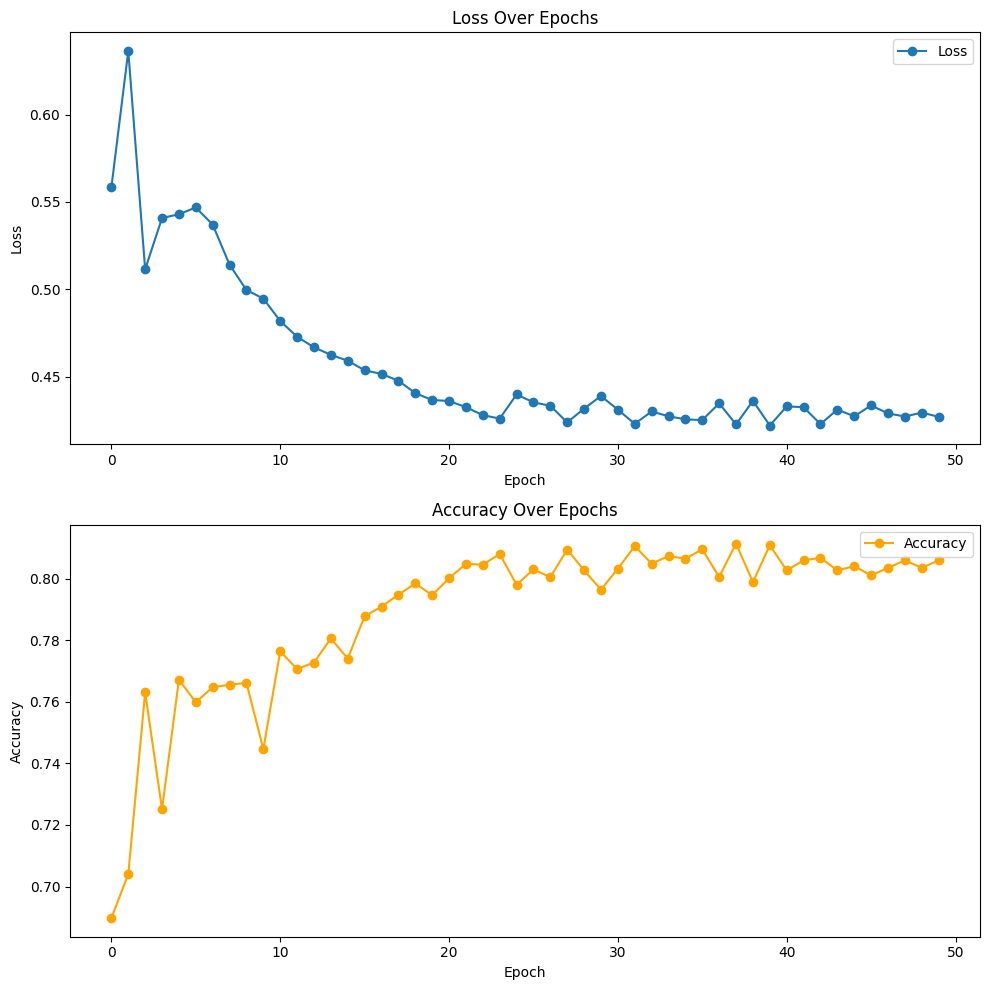

In [269]:
loss_list, accuracy_list = train_model(rnn_model, train_loader_LSTM, num_epochs=50)
plot_loss_acc(loss_list, accuracy_list)

In [270]:
test_accuracy_RNN = eval_model(rnn_model, test_loader_LSTM)
print(f'RNN model accuracy over test dataset: {100*test_accuracy_RNN:.2f}%')

100%|██████████| 2/2 [00:00<00:00, 11.16it/s]

RNN model accuracy over test dataset: 78.85%


In [271]:
input_size = X_train_LSTM.shape[-1]
birnn_model = RNN_smiles(
    input_size,
    hidden_size = 64,
    num_layers = 4,
    bidirectional = True,
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(birnn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

birnn_model

RNN_smiles(
  (rnn): RNN(72, 64, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)

epoch 5/50: 100%|██████████| 7/7 [00:00<00:00, 24.84it/s]


Epoch 5/50, Loss: 0.4413, Accuracy: 80.86%


epoch 10/50: 100%|██████████| 7/7 [00:00<00:00, 24.00it/s]


Epoch 10/50, Loss: 0.3880, Accuracy: 84.51%


epoch 15/50: 100%|██████████| 7/7 [00:00<00:00, 24.24it/s]


Epoch 15/50, Loss: 0.3224, Accuracy: 87.44%


epoch 20/50: 100%|██████████| 7/7 [00:00<00:00, 25.08it/s]


Epoch 20/50, Loss: 0.2719, Accuracy: 88.91%


epoch 25/50: 100%|██████████| 7/7 [00:00<00:00, 25.79it/s]


Epoch 25/50, Loss: 0.2612, Accuracy: 88.40%


epoch 30/50: 100%|██████████| 7/7 [00:00<00:00, 24.87it/s]


Epoch 30/50, Loss: 0.2540, Accuracy: 88.87%


epoch 35/50: 100%|██████████| 7/7 [00:00<00:00, 23.95it/s]


Epoch 35/50, Loss: 0.2534, Accuracy: 89.00%


epoch 40/50: 100%|██████████| 7/7 [00:00<00:00, 24.42it/s]


Epoch 40/50, Loss: 0.2542, Accuracy: 88.59%


epoch 45/50: 100%|██████████| 7/7 [00:00<00:00, 22.70it/s]


Epoch 45/50, Loss: 0.2566, Accuracy: 88.51%


epoch 50/50: 100%|██████████| 7/7 [00:00<00:00, 25.13it/s]


Epoch 50/50, Loss: 0.2498, Accuracy: 89.08%


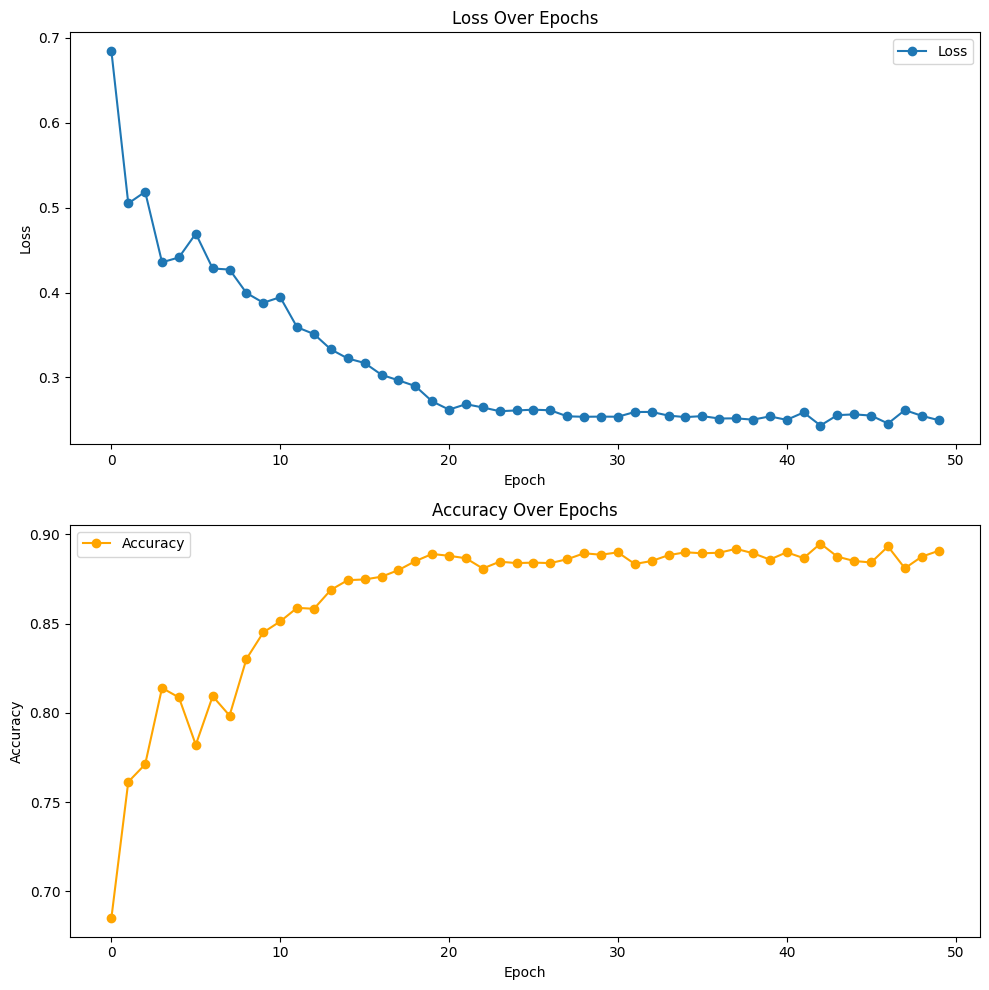

In [272]:
loss_list, accuracy_list = train_model(birnn_model, train_loader_LSTM, num_epochs=50)
plot_loss_acc(loss_list, accuracy_list)

In [273]:
test_accuracy_BiRNN = eval_model(birnn_model, test_loader_LSTM)
print(f'BiRNN model accuracy over test dataset: {100*test_accuracy_BiRNN:.2f}%')

100%|██████████| 2/2 [00:00<00:00, 10.94it/s]

BiRNN model accuracy over test dataset: 86.49%


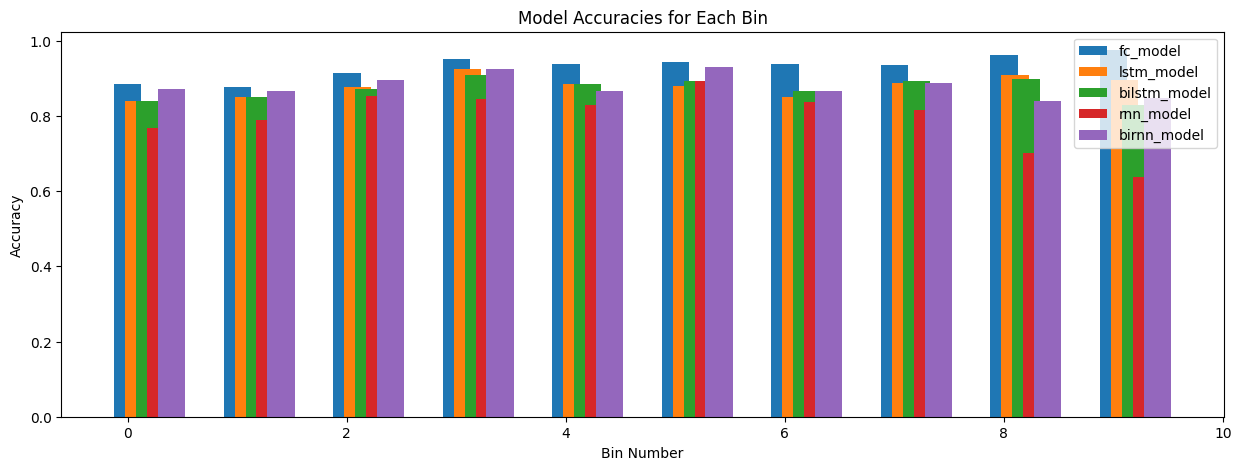

In [274]:
import matplotlib.pyplot as plt

accuracies = {model_name: [] for model_name in ['fc_model', 'lstm_model', 'bilstm_model', 'rnn_model', 'birnn_model']}

for bin_num, bin_idx in bin_indices.items():
    # Evaluate fc_model
    inputs, labels = X_MLP[bin_idx], Y[bin_idx]
    inputs, labels = torch.Tensor(inputs).to(device), torch.Tensor(labels).to(device)
    fc_model.eval()
    fc_predictions = fc_model(inputs)
    fc_predictions = fc_predictions.reshape_as(labels)
    predicted = (fc_predictions > 0.5).float() 
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    fc_accuracy = correct / total
    accuracies['fc_model'].append(fc_accuracy)

    # Evaluate sequential models
    seq_models = [lstm_model, bilstm_model, rnn_model, birnn_model]
    for model, model_name in zip(seq_models, ['lstm_model', 'bilstm_model', 'rnn_model', 'birnn_model']):
        inputs, labels = smiles_onehot[bin_idx], Y[bin_idx]
        inputs, labels = torch.Tensor(inputs).to(device), torch.Tensor(labels).to(device)
        model.eval()
        seq_predictions = model(inputs)
        seq_predictions = seq_predictions.reshape_as(labels)
        predicted = (seq_predictions > 0.5).float() 
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        seq_accuracy = correct / total
        accuracies[model_name].append(seq_accuracy)

# Plotting
bin_numbers = list(bin_indices.keys())
bar_positions = np.arange(len(bin_indices))
plt.figure(figsize=(15, 5))
bar_width = 0.25
num_models = len(accuracies)
for i, model_name in enumerate(['fc_model', 'lstm_model', 'bilstm_model', 'rnn_model', 'birnn_model']):
    plt.bar(bar_positions + 2 * i * bar_width / num_models, accuracies[model_name], width=bar_width, label=model_name)

plt.xlabel('Bin Number')
plt.ylabel('Accuracy')
plt.title('Model Accuracies for Each Bin')
plt.legend()
plt.show()